In [79]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [80]:
df = pd.read_csv("C:\\Users\\user\\Documents\\MSc\\F1_KutMod\\kutmod\\saját_kutatás\\books.csv")

In [81]:
print(f"Dataset size before cleaning: {len(df)} records")

df = df[df['title'].notna() & df['average_rating'].notna()]
df = df[df['title'].str.strip() != ""]
df = df[df['average_rating'] > 0]

print(f"Dataset size after cleaning (non-existent values): {len(df)} records")

df = df[df['language_code'].notna() & df['language_code'].str.strip().str.lower().isin(['en', 'eng', 'en-us', 'en-gb'])]

print(f"Dataset size after cleaning (english only): {len(df)} records")

df = df[df['title'].str.len() < 150]
df = df[df['title'].str.len() > 1]

print(f"Dataset size after cleaning (title length): {len(df)} records")

df = df[df['ratings_count'] >= 100]

print(f"Dataset size after cleaning (review count): {len(df)} records")

Dataset size before cleaning: 11127 records
Dataset size after cleaning (non-existent values): 11101 records
Dataset size after cleaning (english only): 10510 records
Dataset size after cleaning (title length): 10496 records
Dataset size after cleaning (review count): 8198 records


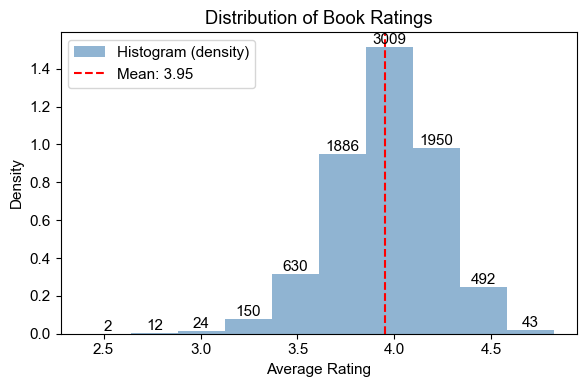

In [93]:
import matplotlib.pyplot as plt

# Histogram with KDE and counts annotated on each bar
plt.figure(figsize=(6,4))

plt.rcParams.update({'font.family': 'arial', 'font.size': 11})

# plot histogram as density for visual match with KDE, but capture returned values to compute counts
n_density, bins, patches = plt.hist(y, bins=10, density=True, alpha=0.6, color='steelblue', label='Histogram (density)')

# compute actual counts per bin from density values
counts = n_density * len(y) * np.diff(bins)

# annotate counts above each bar
for i, patch in enumerate(patches):
    x = (bins[i] + bins[i+1]) / 2
    plt.text(x, n_density[i], f'{int(counts[i])}', ha='center', va='bottom', fontsize=11)

# mean line and labels
plt.axvline(y.mean(), color='red', linestyle='--', label=f'Mean: {y.mean():.2f}')
plt.xlabel('Average Rating')
plt.ylabel('Density')
plt.title('Distribution of Book Ratings')
plt.legend()
plt.tight_layout()
plt.show()

In [110]:
text_features = ['title']
categorical_features = ['authors']
numeric_features = ['num_pages', 'ratings_count', 'text_reviews_count']
target = 'average_rating'

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000, stop_words='english'), 'title'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

In [111]:
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=800,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

In [112]:
X = df[text_features + categorical_features + numeric_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [113]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

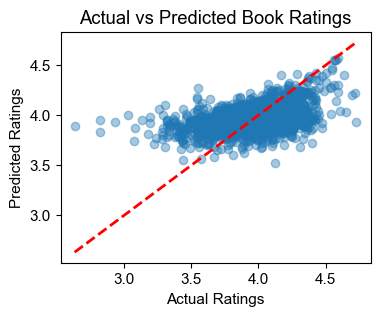

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
plt.rcParams.update({'font.family': 'arial', 'font.size': 11})
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         'r--', linewidth=2)  # line y=x
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Book Ratings")
plt.show()

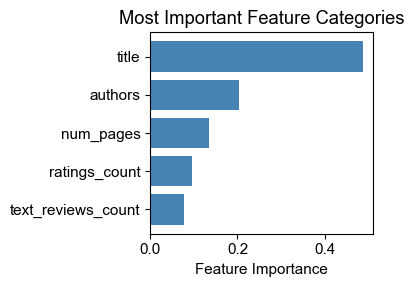

In [121]:
import numpy as np

# Extract feature names from the preprocessor
text_transformer = model.named_steps['preprocess'].named_transformers_['text']
top_feature_names = text_transformer.get_feature_names_out()

cat_transformer = model.named_steps['preprocess'].named_transformers_['cat']
cat_feature_names = cat_transformer.get_feature_names_out()

# Get feature importances from the trained model
importances = model.named_steps['regressor'].feature_importances_

# Calculate number of text features
n_text_features = len(top_feature_names)

# Aggregate TF-IDF features into single "title" importance
title_importance = importances[:n_text_features].sum()

# Aggregate all author one-hot encoded features into single "authors" importance
n_author_features = len(cat_feature_names)
authors_importance = importances[n_text_features:n_text_features + n_author_features].sum()

# Numeric feature importances
numeric_importances = importances[n_text_features + n_author_features:]

# Create aggregated feature importances and names
aggregated_importances = np.concatenate([[title_importance, authors_importance], numeric_importances])
aggregated_feature_names = ['title', 'authors'] + numeric_features

# Get top indices
agg_indices = np.argsort(aggregated_importances)[::-1]

# Visualization of top features
plt.figure(figsize=(4,3))
plt.rcParams.update({'font.family': 'arial', 'font.size': 11})
top_n = min(5, len(aggregated_feature_names))
top_indices = agg_indices[:top_n]
top_importances = aggregated_importances[top_indices]
top_feature_names = [aggregated_feature_names[i] for i in top_indices]

plt.barh(range(top_n), top_importances, color='steelblue')
plt.yticks(range(top_n), top_feature_names)
plt.xlabel("Feature Importance", fontsize=11)
plt.title(f"Most Important Feature Categories")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [122]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate metrics for model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Baseline: always predict the mean rating
baseline_pred = np.full_like(y_test, y_train.mean())

# Calculate metrics for baseline
baseline_mse = mean_squared_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_r2 = r2_score(y_test, baseline_pred)

# Compare with model
print("Model Performance:")
print(f"  MSE:  {mse:.6f}")
print(f"  RMSE: {rmse:.6f}")
print(f"  R²:   {r2:.6f}")
print("\nBaseline (Mean) Performance:")
print(f"  MSE:  {baseline_mse:.6f}")
print(f"  RMSE: {baseline_rmse:.6f}")
print(f"  R²:   {baseline_r2:.6f}")
print("\nImprovement:")
print(f"  MSE reduction:  {((baseline_mse - mse) / baseline_mse * 100):.2f}%")
print(f"  RMSE reduction: {((baseline_rmse - rmse) / baseline_rmse * 100):.2f}%")

Model Performance:
  MSE:  0.054426
  RMSE: 0.233293
  R²:   0.210938

Baseline (Mean) Performance:
  MSE:  0.068981
  RMSE: 0.262642
  R²:   -0.000079

Improvement:
  MSE reduction:  21.10%
  RMSE reduction: 11.17%
